In [1]:
from sklearn import model_selection
from sklearn import metrics
import os
import numpy as np
import pandas as pd
from MicroBiome import MicroBiomeDataSet, Trainer, TrainTester, MultiTrainTester
from sklearn import linear_model as LM
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import stats
import seaborn as sns
import copy

# Load Data

In [2]:
top_dir = '/project'
data_dir = os.path.join(top_dir, 'data')
preproc_dir = os.path.join(data_dir, 'preprocessed')
inp_dir = os.path.join(preproc_dir, 'Gupta_2020_Precompiled_Cleaned')

In [3]:
os.listdir(inp_dir)

['MatrixDataClean.csv', 'SampleMetaDataClean.csv', 'FeatMetaDataClean.csv']

In [4]:
MatrixData = np.loadtxt(os.path.join(inp_dir, 'MatrixDataClean.csv'))
MatrixData.shape

(4347, 903)

In [5]:
SampleMeta = pd.read_csv(os.path.join(inp_dir, 'SampleMetaDataClean.csv'))
SampleMeta

,6,study,Study No. (From VG sheet (V-*) from SB sheet (S-*)),Title of Paper,Author (year),Journal,Study Accession,Sample Accession or Sample ID,Sample title (ENA/SRA),Sample title (Paper),...,Use of milk or milk products (Yes/No/Sometimes),Use of Animal Product- Meat (Yes/No/Vegetarian/Vegan),Alcohol Consumption (Yes/No),Diet1,Intervention for study (Diet),Intervention for study (medication),Sequencing Platform,Library layout (SINGLE/PAIRED),Read count after Quality control,Healthy
0,SAMEA104142287,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142287,ZSL-004,ZSL-004,...,NaN,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,43356775.0,Unhealthy
1,SAMEA104142288,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142288,ZSL-007,ZSL-007,...,NaN,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,41073871.0,Unhealthy
2,SAMEA104142293,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142293,ZSL-010,ZSL-010,...,NaN,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,40199673.0,Unhealthy
3,SAMEA104142291,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142291,ZSL-011,ZSL-011,...,NaN,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,31054158.0,Unhealthy
4,SAMEA104142284,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142284,ZSL-019,ZSL-019,...,NaN,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,36081150.0,Unhealthy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4342,SAMEA4431948,S-7_Underweight,S-7,Two distinct metacommunities characterize the ...,He (2017),Gigascience,PRJEB15371,SAMEA4431948,SZAXPI029564-74,SZAXPI029564-74,...,NaN,NaN,NaN,NaN,No,No,Illumina HiSeq 2000,PAIRED,52212493.0,Unhealthy
4343,SAMEA4431949,S-7_Underweight,S-7,Two distinct metacommunities characterize the ...,He (2017),Gigascience,PRJEB15371,SAMEA4431949,SZAXPI029565-77,SZAXPI029565-77,...,NaN,NaN,NaN,NaN,No,No,Illumina HiSeq 2000,PAIRED,50635879.0,Unhealthy
4344,SAMEA4431951,S-7_Underweight,S-7,Two distinct metacommunities characterize the ...,He (2017),Gigascience,PRJEB15371,SAMEA4431951,SZAXPI029567-80,SZAXPI029567-80,...,NaN,NaN,NaN,NaN,No,No,Illumina HiSeq 2000,PAIRED,40712962.0,Unhealthy
4345,SAMEA4431964,S-7_Underweight,S-7,Two distinct metacommunities characterize the ...,He (2017),Gigascience,PRJEB15371,SAMEA4431964,SZAXPI029580-98,SZAXPI029580-98,...,NaN,NaN,NaN,NaN,No,No,Illumina HiSeq 2000,PAIRED,38177360.0,Unhealthy


In [6]:
FeatMeta = pd.read_csv(os.path.join(inp_dir, 'FeatMetaDataClean.csv'))
FeatMeta

,Unnamed: 0,feature
0,s__Abiotrophia_defectiva,s__Abiotrophia_defectiva
1,s__Acetobacter_unclassified,s__Acetobacter_unclassified
2,s__Achromobacter_piechaudii,s__Achromobacter_piechaudii
3,s__Achromobacter_unclassified,s__Achromobacter_unclassified
4,s__Achromobacter_xylosoxidans,s__Achromobacter_xylosoxidans
...,...,...
898,s__Weissella_koreensis,s__Weissella_koreensis
899,s__Weissella_paramesenteroides,s__Weissella_paramesenteroides
900,s__Weissella_unclassified,s__Weissella_unclassified
901,s__Wohlfahrtiimonas_chitiniclastica,s__Wohlfahrtiimonas_chitiniclastica


# Run PCA

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(MatrixData)

In [8]:
# Do all principal components
pca_model = PCA(n_components = None)

In [9]:
X_PCA = pca_model.fit_transform(X_scaled)

In [10]:
X_PCA.shape

(4347, 903)

<AxesSubplot:>

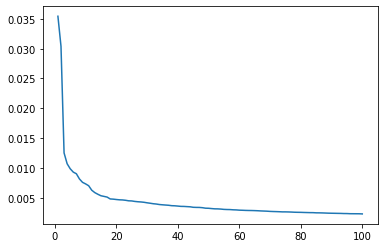

In [11]:
sns.lineplot(x = np.arange(1,101), y = pca_model.explained_variance_ratio_[0:100])

<AxesSubplot:>

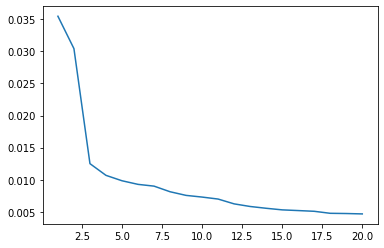

In [12]:
sns.lineplot(x = np.arange(1,21), y = pca_model.explained_variance_ratio_[0:20])

In [13]:
# get median absolute deviation of components to see where variance is not affected by outliers
mad_vals = np.array([stats.median_absolute_deviation(X_scaled[:, i]) for i in range(X_scaled.shape[1])])

/root/anaconda/envs/microbiome/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `median_absolute_deviation` is deprecated, use `median_abs_deviation` instead!

To preserve the existing default behavior, use
`scipy.stats.median_abs_deviation(..., scale=1/1.4826)`.
The value 1.4826 is not numerically precise for scaling
with a normal distribution. For a numerically precise value, use
`scipy.stats.median_abs_deviation(..., scale='normal')`.

  


<AxesSubplot:>

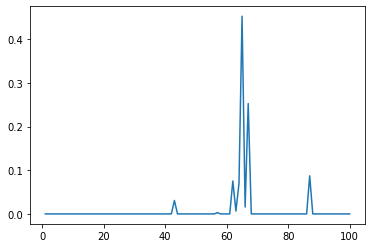

In [14]:
sns.lineplot(x = np.arange(1,101), y = mad_vals[0:100])

In [15]:
mad_ordered_PCs = np.argsort(-mad_vals)
mad_ordered_PCs

array([401, 327, 284, 856, 393,  64, 608, 283, 764, 768, 328, 152, 389,
       630, 153, 170,  66, 270, 388, 750, 620, 112, 766, 758, 475, 157,
       748, 473, 151, 392, 128, 469, 166, 397, 110, 627, 749,  86,  61,
       154, 117,  63, 171, 839,  42, 235, 150, 378, 833, 159, 465,  65,
       891, 113, 249, 383,  62, 395,  56, 122, 763, 430, 762, 886, 125,
       237, 680, 603, 609, 590, 594, 607, 599, 600, 601, 596, 597, 606,
       591, 593, 605, 604, 592, 595, 602, 598, 621, 611, 645, 646, 647,
       648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660,
       661, 662, 663, 664, 665, 666, 667, 668, 669, 644, 643, 642, 641,
       612, 613, 614, 615, 616, 617, 618, 619, 589, 622, 623, 624, 610,
       625, 628, 629, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640,
       626, 588, 571, 586, 505, 506, 507, 508, 509, 510, 511, 512, 513,
       514, 515, 504, 516, 518, 519, 520, 521, 522, 523, 524, 525, 526,
       527, 528, 517, 503, 502, 501, 476, 477, 478, 479, 480, 48

In [16]:
mad_vals.shape

(903,)

<AxesSubplot:>

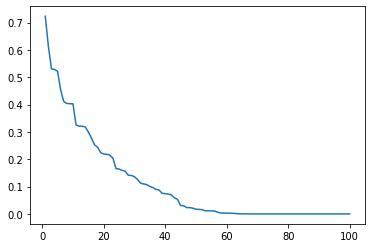

In [17]:
sns.lineplot(x = np.arange(1,101), y = mad_vals[mad_ordered_PCs[0:100]])

In [18]:
pca_model.components_.shape

(903, 903)

In [19]:
heatmap_df = FeatMeta
for i in range(21):
    pc_use = mad_ordered_PCs[i]
    PC_name = 'PC' + str(pc_use)
    heatmap_df[PC_name] = pca_model.components_[pc_use,:]

heatmap_df.index = heatmap_df['feature']
heatmap_df.pop('Unnamed: 0')
heatmap_df.pop('feature')
heatmap_df

,PC401,PC327,PC284,PC856,PC393,PC64,PC608,PC283,PC764,PC768,...,PC152,PC389,PC630,PC153,PC170,PC66,PC270,PC388,PC750,PC620
feature,,,,,,,,,,,,,,,,,,,,,
s__Abiotrophia_defectiva,-0.013835,-0.045971,0.009460,0.000000e+00,-0.019662,-0.047070,0.116151,0.000373,-0.000218,0.000410,...,0.042236,-0.037972,-0.056399,-0.004562,-0.003188,0.002830,-0.023257,0.037969,0.001119,0.107507
s__Acetobacter_unclassified,-0.007864,0.014834,-0.045145,-1.190590e-16,-0.027621,-0.004499,-0.008090,0.073763,0.000022,0.000111,...,-0.053173,0.054227,0.002458,0.045242,-0.100887,-0.006064,-0.005983,-0.033475,0.000217,0.001387
s__Achromobacter_piechaudii,0.009559,-0.022000,-0.002332,2.438997e-03,0.013743,-0.003101,0.014706,0.003540,-0.003398,0.000243,...,0.008849,-0.008621,0.015012,-0.022864,0.010774,-0.010552,0.009532,0.005531,-0.000272,-0.010070
s__Achromobacter_unclassified,-0.003058,-0.015003,-0.011863,8.809512e-04,-0.005017,0.003116,0.010800,-0.004377,0.013356,0.001297,...,0.003476,-0.004435,0.028981,-0.005657,0.005734,-0.008705,0.002659,0.000458,-0.003102,-0.013248
s__Achromobacter_xylosoxidans,0.009559,-0.022000,-0.002332,-2.841826e-03,0.013743,-0.003101,0.014706,0.003540,-0.003398,0.000243,...,0.008849,-0.008621,0.015012,-0.022864,0.010774,-0.010552,0.009532,0.005531,-0.000272,-0.010070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s__Weissella_koreensis,-0.018546,0.184839,0.005493,5.339696e-18,-0.058532,0.001181,-0.010047,-0.025556,-0.000105,-0.000101,...,0.059589,0.020043,-0.018785,-0.018519,0.026036,-0.001547,-0.051393,-0.011074,-0.000204,0.013130
s__Weissella_paramesenteroides,0.014591,0.018052,0.001772,7.032406e-17,0.002037,0.003355,0.004857,-0.006891,0.000026,-0.000037,...,0.019343,0.021937,0.016210,-0.010557,-0.013766,0.005518,0.024782,0.018275,-0.000121,0.029931
s__Weissella_unclassified,0.017851,-0.002413,0.013307,-5.421011e-20,0.021252,0.025156,0.039277,0.009207,0.001904,0.000116,...,0.001177,-0.012722,0.079489,-0.085597,-0.039146,0.081264,0.017742,0.005333,-0.000639,0.000407


/root/anaconda/envs/microbiome/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


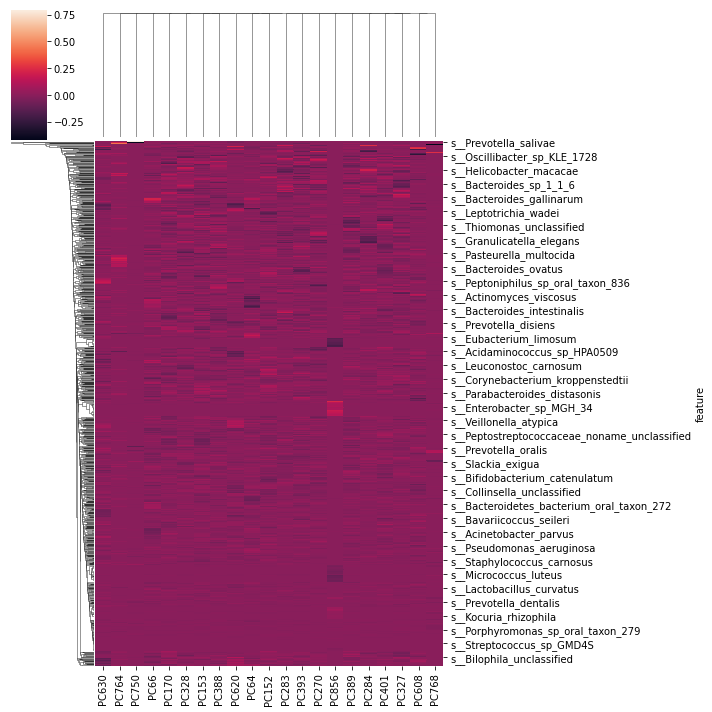

In [20]:
sns.clustermap(heatmap_df)

Overall, we don't see super blocky strucutre

In [21]:
# get maximum PC loading
max_loading = np.array([np.max(pca_model.components_[mad_ordered_PCs[0:20], i]) for i in range(pca_model.components_.shape[1])])

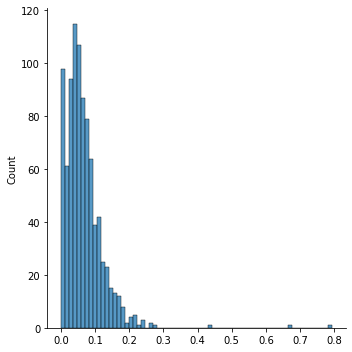

In [22]:
# distribution of maximum PC loadings across ~900 features
sns.displot(max_loading)

It seems like most features are at least somewhat important, while there are a handful that are really important to variation

In [23]:
heatmap_df['PC401'].sort_values(ascending = False)[0:40]

feature
s__Corynebacterium_propinquum             0.186361
s__Brachybacterium_unclassified           0.151163
s__Bacteroides_dorei                      0.140839
s__Thiomonas_unclassified                 0.106664
s__Bifidobacterium_breve                  0.099312
s__Mitsuokella_unclassified               0.094349
s__Alistipes_onderdonkii                  0.093425
s__Eubacterium_eligens                    0.090238
s__Prevotella_sp_oral_taxon_473           0.086387
s__Eubacterium_siraeum                    0.085613
s__Eggerthella_lenta                      0.083803
s__Anaerococcus_lactolyticus              0.083032
s__Megasphaera_micronuciformis            0.081759
s__Desulfovibrio_desulfuricans            0.080626
s__Coprococcus_eutactus                   0.078037
s__Streptococcus_pyogenes                 0.077575
s__Holdemania_unclassified                0.073380
s__Ruminococcus_callidus                  0.072734
s__Alistipes_putredinis                   0.072536
s__Fusobacterium_mortif

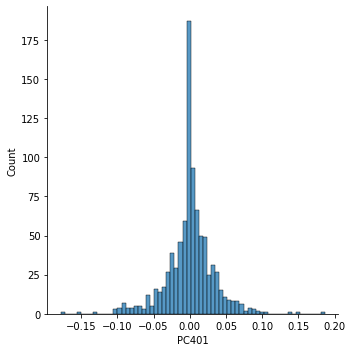

In [24]:
sns.displot(heatmap_df['PC401'])

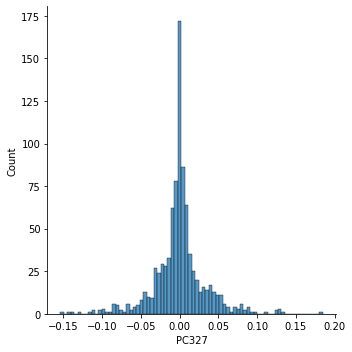

In [25]:
sns.displot(heatmap_df['PC327'])

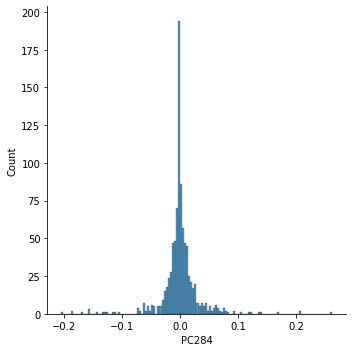

In [26]:
sns.displot(heatmap_df['PC284'])

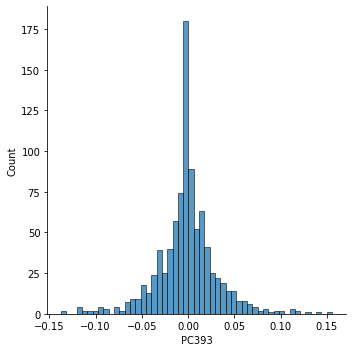

In [27]:
sns.displot(heatmap_df['PC393'])

Individual PCs with large MAD tend to be dominated by a small minority of features

In [29]:
for i in range(0, 100):
    pc_use = mad_ordered_PCs[i]
    PC_name = 'PC' + str(pc_use)
    SampleMeta[PC_name] = X_PCA[:, pc_use]

In [30]:
mad_ordered_PCs[0:20]

array([401, 327, 284, 856, 393,  64, 608, 283, 764, 768, 328, 152, 389,
       630, 153, 170,  66, 270, 388, 750])

<AxesSubplot:xlabel='PC401', ylabel='PC327'>

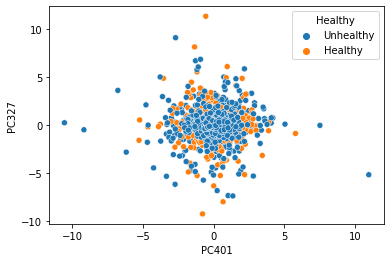

In [31]:
sns.scatterplot(data = SampleMeta, x = 'PC401', y = 'PC327', hue = 'Healthy')

<AxesSubplot:xlabel='PC284', ylabel='PC856'>

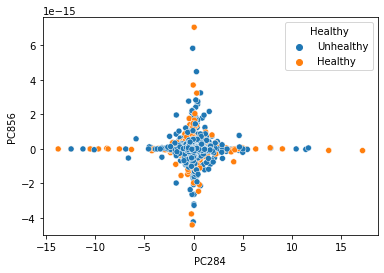

In [33]:
sns.scatterplot(data = SampleMeta, x = 'PC284', y = 'PC856', hue = 'Healthy')

<AxesSubplot:xlabel='PC393', ylabel='PC64'>

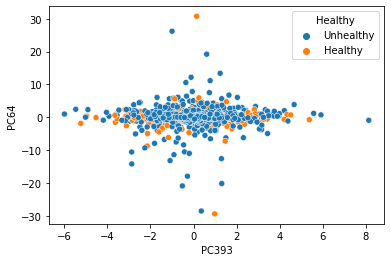

In [34]:
sns.scatterplot(data = SampleMeta, x = 'PC393', y = 'PC64', hue = 'Healthy')

In [40]:
healthy_inds = np.argwhere(SampleMeta['Healthy'].to_numpy() == 'Healthy')
unhealthy_inds = np.argwhere(SampleMeta['Healthy'].to_numpy() != 'Healthy')

In [42]:
t_test_results = {'PC': [], 't': [], 'p': []}
for x in mad_ordered_PCs[0:40]:
    pc_name = 'PC'+str(x)
    pc_vals = SampleMeta[pc_name].to_numpy().astype('float')
    t_test_result_x = stats.ttest_ind(pc_vals[healthy_inds], pc_vals[unhealthy_inds])
    t_test_results['PC'].append(pc_name)
    t_test_results['t'].append(t_test_result_x[0])
    t_test_results['p'].append(t_test_result_x[1])

In [43]:
t_test_results = pd.DataFrame(t_test_results)
t_test_results

,PC,t,p
0,PC401,[0.23859044235526175],[0.811434428600488]
1,PC327,[1.4417169670106988],[0.14945430317122305]
2,PC284,[-0.42470998559117085],[0.6710691326635554]
3,PC856,[0.4654992373595321],[0.6415973132411332]
4,PC393,[-0.9886548810889729],[0.3228870759355986]
5,PC64,[-2.5167908024964856],[0.011878630094103938]
6,PC608,[-0.054207246172450846],[0.9567725396976555]
7,PC283,[-1.1472792971266372],[0.25132937569963537]
8,PC764,[0.6190757693414745],[0.5358989011275623]
9,PC768,[0.40098678316235153],[0.6884495719467583]


<AxesSubplot:xlabel='PC61', ylabel='PC64'>

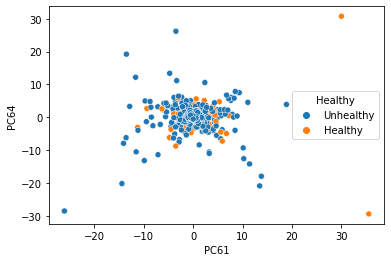

In [44]:
sns.scatterplot(data = SampleMeta, x = 'PC61', y = 'PC64', hue = 'Healthy')

<AxesSubplot:xlabel='PC151', ylabel='PC112'>

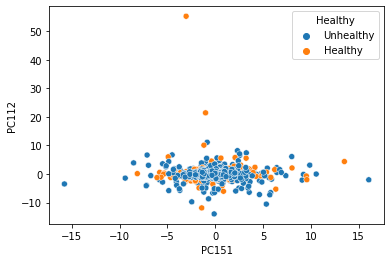

In [45]:
sns.scatterplot(data = SampleMeta, x = 'PC151', y = 'PC112', hue = 'Healthy')

<AxesSubplot:xlabel='PC151', ylabel='PC86'>

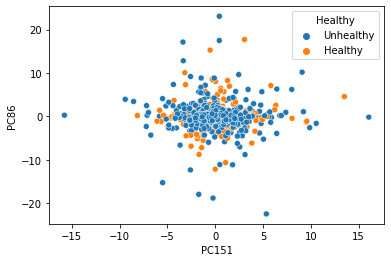

In [46]:
sns.scatterplot(data = SampleMeta, x = 'PC151', y = 'PC86', hue = 'Healthy')